# &#x1F4D1; &nbsp;  Image Generator of Digits
## Libraries

In [28]:
%%html
<style>        
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #39d4be; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #39d4be; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt {color: #39d4be;} 
div.output_area pre, div.output_subarea {color: slategrey;}
div.input_prompt {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;} 
</style>

In [3]:
import numpy as np 
import pandas as pd
import math
from scipy import misc
from collections import namedtuple

import cv2
from PIL import ImageFile, Image
from tqdm import tqdm
from glob import glob

from keras.preprocessing import image as keras_image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tflearn

from keras.layers import Input, Dense, Reshape
from keras.layers import Activation, LeakyReLU, BatchNormalization, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam, Nadam
from keras import backend

from tflearn.data_utils import build_hdf5_image_dataset

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
from matplotlib import cm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## Dataset

In [6]:
# Function for processing an image
def image_to_tensor(img_path, folder_path):
    img = keras_image.load_img(folder_path + img_path, target_size=(32, 32))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths, folder_path):
    list_of_tensors = [image_to_tensor(img_path, folder_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
# Load the data
data = pd.read_csv("/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data2/letters2.csv")

files = data['file']
letters = data['letter']
tensors = data_to_tensor(files, "/Users/olgabelitskaya/deep_learning_projects/DL_PP2/data2/");

100%|██████████| 5940/5940 [02:54<00:00, 33.97it/s]


In [29]:
# Print the shape 
print ('Tensor shape:', tensors.shape)

Tensor shape: (5940, 32, 32, 3)


In [15]:
# Normalize the tensors
tensors = tensors.astype('float32')/255

Label:  к


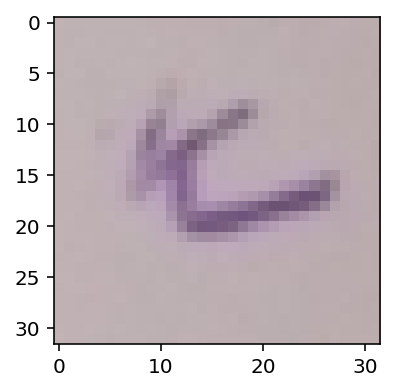

In [16]:
# Display an example
print('Label: ', letters[2000])
plt.figure(figsize=(3,3))
plt.imshow(tensors[2000]);

In [160]:
# Create grayscale negative tensors
gray_tensors = 1 - np.dot(tensors[...,:3], [0.299, 0.587, 0.114])
gray_tensors = gray_tensors.reshape(-1, 32*32)
print ('Grayscaled tensor shape:', gray_tensors.shape)

Grayscaled tensor shape: (5940, 1024)


Label:  к


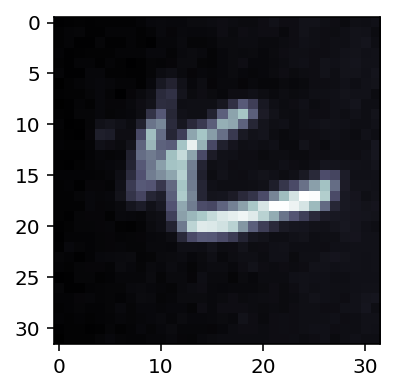

In [161]:
# Display an example
print('Label: ', letters[2000])
plt.figure(figsize=(3,3))
plt.imshow(gray_tensors[2000].reshape(32, 32), cmap=cm.bone);

In [178]:
# Create random images
def latent_samples(n_samples, sample_size):
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))
latent_sample_1024 = latent_samples(1, 1024)
latent_sample_128 = latent_samples(1, 128)

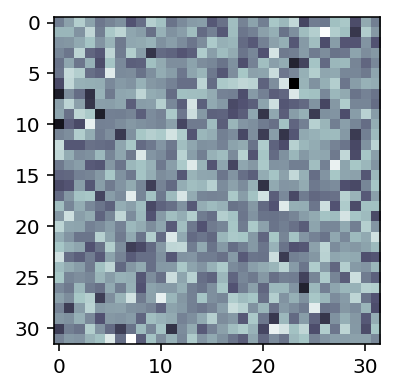

In [179]:
# Display an example
plt.figure(figsize=(3,3))
plt.imshow(np.squeeze(latent_sample_1024).reshape(32, 32), cmap=cm.bone);

In [180]:
X_train_real, X_test_real = train_test_split(gray_tensors, test_size = 0.1)
X_train_real.shape, X_test_real.shape

((5346, 1024), (594, 1024))

In [181]:
def preprocess(x):    
    x = (x - 0.25) * 2
    x = np.clip(x, -1, 1)
    return x
def deprocess(x):
    x = (x / 2 + 0.5) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(32, 32)
    return x

In [182]:
X_train_real = preprocess(X_train_real)
X_test_real  = preprocess(X_test_real)

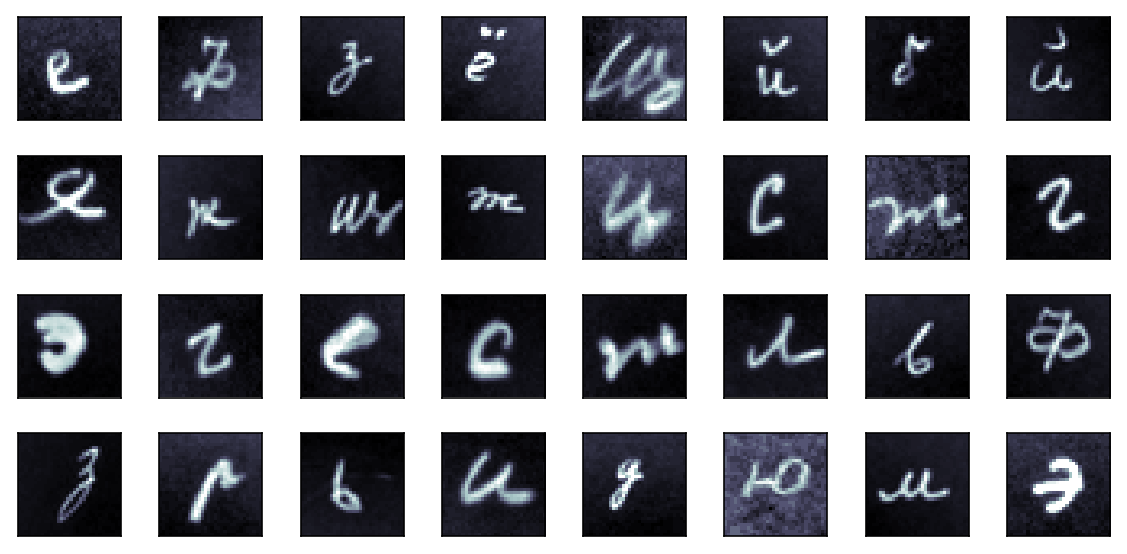

In [183]:
plt.figure(figsize=(8, 4))
for i in range(32):
    img = deprocess(X_train_real[i])
    plt.subplot(4, 8, i+1)
    plt.imshow(img, cmap=cm.bone)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

## Keras GAN
[`"Using GAN for Generating Hand-written Digit Images" by Naoki Shibuya`](https://github.com/naokishibuya/deep-learning/blob/master/python/gan_mnist.ipynb)

In [184]:
discriminator = Sequential([Dense(128, input_shape=(1024,)),
                            LeakyReLU(alpha=0.01),
                            Dense(1),
                            Activation('sigmoid')], 
                           name='discriminator')

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 128)               131200    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_11 (Activation)   (None, 1)                 0         
Total params: 131,329
Trainable params: 131,329
Non-trainable params: 0
_________________________________________________________________


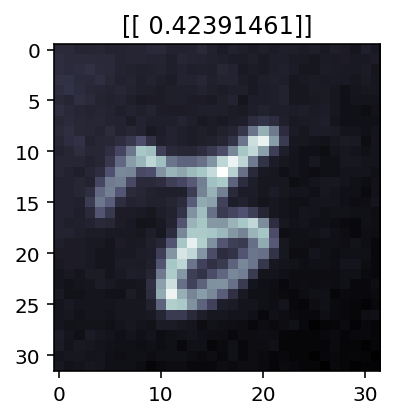

In [185]:
plt.figure(figsize=(3,3))
plt.title(discriminator.predict(X_train_real[1000].reshape(1, 1024)))
plt.imshow(X_train_real[1000].reshape(32, 32), cmap=cm.bone);

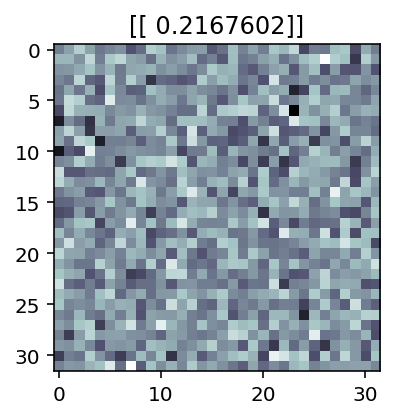

In [186]:
plt.figure(figsize=(3,3))
plt.title(discriminator.predict(latent_sample_1024))
plt.imshow(np.squeeze(latent_sample_1024).reshape(32, 32), cmap=cm.bone);

In [187]:
generator = Sequential([Dense(1024, input_shape=(128,)),
                        LeakyReLU(alpha=0.01),
                        Dense(1024),
                        Activation('tanh')], 
                       name='generator')

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 1024)              132096    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
activation_12 (Activation)   (None, 1024)              0         
Total params: 1,181,696
Trainable params: 1,181,696
Non-trainable params: 0
_________________________________________________________________


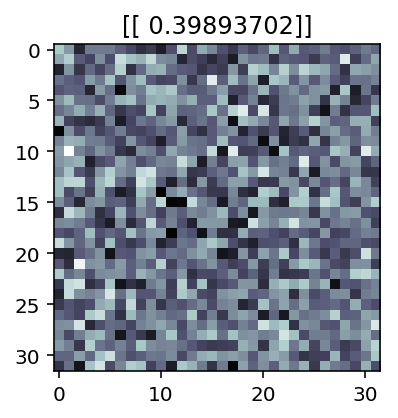

In [188]:
plt.figure(figsize=(3,3))
generated_latent_sample = generator.predict(latent_sample_128)
plt.title(discriminator.predict(generated_latent_sample))
plt.imshow(generated_latent_sample.reshape(32, 32), cmap=cm.bone);

In [189]:
gan = Sequential([generator,discriminator])
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 1024)              1181696   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 131329    
Total params: 1,313,025
Trainable params: 1,313,025
Non-trainable params: 0
_________________________________________________________________


In [190]:
def trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [191]:
def simple_GAN(sample_size, 
               g_hidden_size, 
               d_hidden_size, 
               leaky_alpha, 
               g_learning_rate,
               d_learning_rate):
    
    backend.clear_session()
    
    generator = Sequential([Dense(g_hidden_size, input_shape=(sample_size,)),
                            LeakyReLU(alpha=leaky_alpha),
                            Dense(1024), Activation('tanh')], 
                           name='generator')    

    discriminator = Sequential([Dense(d_hidden_size, input_shape=(1024,)),
                                LeakyReLU(alpha=leaky_alpha),
                                Dense(1),
                                Activation('sigmoid')], 
                               name='discriminator')    
    
    gan = Sequential([generator, discriminator])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator

In [192]:
def real_fake_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [193]:
y_real5, y_fake5 = real_fake_labels(5)
print('Real\n', y_real5)
print('Fake\n', y_fake5)

Real
 [[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
Fake
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


In [194]:
sample_size     = 128     
g_hidden_size   = 1024     # generator
d_hidden_size   = 128     # discriminator
leaky_alpha     = 0.01
g_learning_rate = 0.0001  # generator
d_learning_rate = 0.001   # discriminator
epochs          = 250
batch_size      = 64      
valid_size      = 16     
smooth          = 0.1